<a href="https://colab.research.google.com/github/Dre2322/DSC-400/blob/main/DSC400_mod5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Customer Interactions Exploration") \
    .getOrCreate()


In [2]:
# Load dataset
file_path = 'customer_interactions.csv'
customer_interactions_df = spark.read.csv(file_path, header=True, inferSchema=True)


In [3]:
# Display the first few rows
print("First Few Rows of Data:")
customer_interactions_df.show(5)


First Few Rows of Data:
+----------+---------+-------------------+---------+-------+-------+
|CustomerID|EventType|     EventTimestamp|SessionID|Browser|     OS|
+----------+---------+-------------------+---------+-------+-------+
|     12147| purchase|2021-07-16 16:23:30|   940350|  Opera|Windows|
|     16521|     view|2021-02-12 14:59:19|   707398|   Edge|Windows|
|     13215| purchase|2021-07-21 15:40:10|   495004|Firefox|    iOS|
|     11089|     view|2021-03-26 04:02:13|   963576|Firefox|Android|
|     18626|     view|2021-05-14 02:11:45|   796383|Firefox|Windows|
+----------+---------+-------------------+---------+-------+-------+
only showing top 5 rows



In [4]:
# Print the schema to understand the structure of the dataset
print("Schema of the Dataset:")
customer_interactions_df.printSchema()


Schema of the Dataset:
root
 |-- CustomerID: integer (nullable = true)
 |-- EventType: string (nullable = true)
 |-- EventTimestamp: timestamp (nullable = true)
 |-- SessionID: integer (nullable = true)
 |-- Browser: string (nullable = true)
 |-- OS: string (nullable = true)



In [5]:
# Count the total rows in the dataset
print(f"Total Rows: {customer_interactions_df.count()}")


Total Rows: 10000


In [6]:
# Perform basic statistics for numeric columns
print("Summary Statistics for Numeric Columns:")
customer_interactions_df.describe().show()


Summary Statistics for Numeric Columns:
+-------+-----------------+---------+------------------+-------+-------+
|summary|       CustomerID|EventType|         SessionID|Browser|     OS|
+-------+-----------------+---------+------------------+-------+-------+
|  count|            10000|    10000|             10000|  10000|  10000|
|   mean|       15022.5684|     NULL|       546851.6581|   NULL|   NULL|
| stddev|2894.248682588463|     NULL|259465.87716358845|   NULL|   NULL|
|    min|            10000|    click|            100022| Chrome|Android|
|    max|            19999|     view|            999637| Safari|  macOS|
+-------+-----------------+---------+------------------+-------+-------+



In [7]:
# Check the distinct values in EventType
print("Distinct Event Types:")
customer_interactions_df.select("EventType").distinct().show()


Distinct Event Types:
+---------+
|EventType|
+---------+
|   logout|
|    login|
| purchase|
|     view|
|    click|
+---------+



In [8]:
# Count occurrences of each EventType
print("EventType Counts:")
customer_interactions_df.groupBy("EventType").count().show()


EventType Counts:
+---------+-----+
|EventType|count|
+---------+-----+
|   logout| 2020|
|    login| 1977|
| purchase| 1944|
|     view| 2064|
|    click| 1995|
+---------+-----+



In [9]:
# Analyze top browsers used
print("Top Browsers Used:")
customer_interactions_df.groupBy("Browser").count().orderBy("count", ascending=False).show()


Top Browsers Used:
+-------+-----+
|Browser|count|
+-------+-----+
|   Edge| 2045|
|  Opera| 2017|
|Firefox| 2007|
| Chrome| 1990|
| Safari| 1941|
+-------+-----+



In [10]:
# Analyze top operating systems used
print("Top Operating Systems Used:")
customer_interactions_df.groupBy("OS").count().orderBy("count", ascending=False).show()


Top Operating Systems Used:
+-------+-----+
|     OS|count|
+-------+-----+
|Android| 2102|
|Windows| 1986|
|  macOS| 1974|
|    iOS| 1972|
|  Linux| 1966|
+-------+-----+



In [11]:
# Step 11: Analyze events by time
print("Events by Year and Month:")
from pyspark.sql.functions import year, month
customer_interactions_df \
    .withColumn("Year", year("EventTimestamp")) \
    .withColumn("Month", month("EventTimestamp")) \
    .groupBy("Year", "Month") \
    .count() \
    .orderBy("Year", "Month") \
    .show()


Events by Year and Month:
+----+-----+-----+
|Year|Month|count|
+----+-----+-----+
|2021|    1|  841|
|2021|    2|  721|
|2021|    3|  831|
|2021|    4|  867|
|2021|    5|  894|
|2021|    6|  812|
|2021|    7|  942|
|2021|    8|  824|
|2021|    9|  756|
|2021|   10|  883|
|2021|   11|  815|
|2021|   12|  814|
+----+-----+-----+



## Explanation of the Steps

1. Initialize Spark Session: This creates a connection to Spark.
2. Load Dataset: Reads the CSV file with schema inference and header enabled.
3. Schema & Rows: Displays the structure and a preview of the dataset.
4. Summary Statistics: Summarizes numeric columns.
5. Categorical Analysis: Shows distinct event types and their counts.
6. Browser & OS Trends: Analyzes the most used browsers and operating systems.
7. Time-Based Analysis: Groups data by year and month for temporal trends.

In [12]:
from pyspark.sql.functions import col, when, lit, year, month
from pyspark.sql.types import TimestampType

# Drop rows with all null values
customer_interactions_df = customer_interactions_df.dropna(how="all")


Drop Rows with All Nulls:

- Removes rows where all columns are null.


In [13]:
# Fill missing values for specific columns
# Assuming default values based on the data context
customer_interactions_df = customer_interactions_df.fillna({
    "EventType": "unknown",        # Replace missing event types with 'unknown'
    "Browser": "unknown",          # Replace missing browser values with 'unknown'
    "OS": "unknown"                # Replace missing OS values with 'unknown'
})


Fill Missing Values:

- Replaces missing values in specific columns with reasonable defaults (e.g., "unknown").


In [14]:
# Handle missing or invalid timestamps
# Convert 'EventTimestamp' to TimestampType
customer_interactions_df = customer_interactions_df.withColumn(
    "EventTimestamp",
    when(col("EventTimestamp").isNull(), lit(None)).otherwise(col("EventTimestamp").cast(TimestampType()))
)


Fix Timestamps:

- Ensures EventTimestamp is converted to a valid TimestampType. Invalid timestamps are set to null.

In [15]:
# Filter out rows with null 'EventTimestamp' after conversion
customer_interactions_df = customer_interactions_df.filter(col("EventTimestamp").isNotNull())


Remove Rows with Invalid Timestamps:

- Filters rows where timestamps remain null after conversion.

In [16]:
# Standardize string formats
# Convert all string columns to lowercase for consistency
string_columns = [field.name for field in customer_interactions_df.schema.fields if field.dataType == "StringType"]
for col_name in string_columns:
    customer_interactions_df = customer_interactions_df.withColumn(col_name, col(col_name).lower())


Standardize Formats:

- Converts string columns to lowercase for consistency, preventing duplicates or errors due to case differences.

In [17]:
# Remove duplicates if any
customer_interactions_df = customer_interactions_df.dropDuplicates()


Remove Duplicates:

- Ensures the dataset doesn't have duplicate rows.

In [18]:
# Verify data quality after cleaning
print("Data after addressing missing values and inconsistencies:")
customer_interactions_df.show(5)


Data after addressing missing values and inconsistencies:
+----------+---------+-------------------+---------+-------+-------+
|CustomerID|EventType|     EventTimestamp|SessionID|Browser|     OS|
+----------+---------+-------------------+---------+-------+-------+
|     19677|    click|2021-12-25 04:39:37|   807860|  Opera|    iOS|
|     10805|    click|2021-08-03 23:37:19|   666596|Firefox|Windows|
|     18396|    click|2021-11-23 03:18:51|   626992| Safari|Windows|
|     17643|   logout|2021-09-07 15:56:07|   931814|   Edge|Windows|
|     14462|    login|2021-03-23 10:25:05|   542937|  Opera|Windows|
+----------+---------+-------------------+---------+-------+-------+
only showing top 5 rows



Verify Cleaned Data:

- Displays the cleaned data for inspection.


In [19]:
# Check for remaining nulls and inconsistencies
print("Remaining Null Counts:")
customer_interactions_df.select([(col(c).isNull().cast("int").alias(c)) for c in customer_interactions_df.columns]).groupBy().sum().show()


Remaining Null Counts:
+---------------+--------------+-------------------+--------------+------------+-------+
|sum(CustomerID)|sum(EventType)|sum(EventTimestamp)|sum(SessionID)|sum(Browser)|sum(OS)|
+---------------+--------------+-------------------+--------------+------------+-------+
|              0|             0|                  0|             0|           0|      0|
+---------------+--------------+-------------------+--------------+------------+-------+



Check Remaining Nulls:

- Counts null values in each column after cleaning to confirm data quality.

In [20]:
from pyspark.sql.functions import unix_timestamp, count, max, min
from pyspark.sql.window import Window

# Calculate session duration
# Convert EventTimestamp to Unix timestamp for calculations
customer_interactions_df = customer_interactions_df.withColumn(
    "EventTimestampUnix", unix_timestamp(col("EventTimestamp"))
)

# Calculate the session duration by finding the max and min timestamps for each session
session_window = Window.partitionBy("SessionID")
customer_interactions_df = customer_interactions_df.withColumn(
    "SessionDuration",
    max(col("EventTimestampUnix")).over(session_window) - min(col("EventTimestampUnix")).over(session_window) # Use max and min aggregate functions within the window
)

 Session Duration

- Objective: Calculate the duration of each session.
- Approach:
-- Convert EventTimestamp to Unix timestamp.
-- Use a window function partitioned by SessionID to calculate the difference between the maximum and minimum timestamps within the session.

In [21]:
# Categorize user activity levels
# Count the number of interactions per customer
customer_activity_df = customer_interactions_df.groupBy("CustomerID").agg(
    count("EventType").alias("InteractionCount")
)

# Define activity levels based on interaction counts
customer_activity_df = customer_activity_df.withColumn(
    "ActivityLevel",
    when(col("InteractionCount") <= 5, "Low")
    .when((col("InteractionCount") > 5) & (col("InteractionCount") <= 20), "Medium")
    .otherwise("High")
)

# Join the activity levels back to the original dataset
customer_interactions_df = customer_interactions_df.join(
    customer_activity_df.select("CustomerID", "ActivityLevel"),
    on="CustomerID",
    how="left"
)


Activity Levels

- Objective: Categorize customers based on their interaction counts.
- Approach:
-- Aggregate the dataset to count the number of interactions for each customer (InteractionCount).
-- Define activity levels:
-- - Low: ≤5 interactions.
-- - Medium: 6–20 interactions.
-- - High: >20 interactions.

In [22]:
# Verify new features
print("Dataset with New Features:")
customer_interactions_df.select(
    "CustomerID", "SessionID", "SessionDuration", "ActivityLevel", "EventType"
).show(10)


Dataset with New Features:
+----------+---------+---------------+-------------+---------+
|CustomerID|SessionID|SessionDuration|ActivityLevel|EventType|
+----------+---------+---------------+-------------+---------+
|     13759|   100022|              0|          Low|   logout|
|     19861|   100138|              0|          Low|    login|
|     16921|   100458|              0|          Low|     view|
|     18632|   100748|              0|          Low|    click|
|     15325|   100785|              0|          Low|    login|
|     10973|   100831|              0|          Low| purchase|
|     18207|   100907|              0|          Low|    click|
|     12758|   100940|              0|          Low|    click|
|     11468|   101072|              0|          Low|     view|
|     14466|   101084|              0|          Low|   logout|
+----------+---------+---------------+-------------+---------+
only showing top 10 rows



Joining Activity Levels
- Objective: Add the ActivityLevel feature to the original dataset for further analysis.

## Insights Uncovered
1. Session Durations: Provides insight into customer engagement during individual sessions.
2. Activity Levels: Segments customers into behavioral categories for targeted analysis or marketing.


In [23]:
# Register the DataFrame as a SQL table
customer_interactions_df.createOrReplaceTempView("customer_interactions")


In [24]:
# Analyze event frequencies per customer
print("Event Frequencies Per Customer:")
spark.sql("""
    SELECT
        CustomerID,
        EventType,
        COUNT(*) AS EventCount
    FROM
        customer_interactions
    GROUP BY
        CustomerID, EventType
    ORDER BY
        CustomerID, EventType
""").show()


Event Frequencies Per Customer:
+----------+---------+----------+
|CustomerID|EventType|EventCount|
+----------+---------+----------+
|     10000|   logout|         1|
|     10000| purchase|         1|
|     10002|    click|         1|
|     10004|    click|         2|
|     10005|    click|         1|
|     10005| purchase|         2|
|     10005|     view|         2|
|     10006|    login|         1|
|     10006|   logout|         1|
|     10008|    click|         1|
|     10009|     view|         1|
|     10010|    click|         1|
|     10010|     view|         1|
|     10012| purchase|         1|
|     10016|   logout|         1|
|     10016|     view|         1|
|     10019|   logout|         1|
|     10021|    click|         1|
|     10021| purchase|         1|
|     10023|   logout|         2|
+----------+---------+----------+
only showing top 20 rows



Event Frequencies Per Customer
- Groups the data by CustomerID and EventType to calculate the frequency of each event type for every customer.

In [25]:
# Analyze event frequencies per session
print("Event Frequencies Per Session:")
spark.sql("""
    SELECT
        SessionID,
        EventType,
        COUNT(*) AS EventCount
    FROM
        customer_interactions
    GROUP BY
        SessionID, EventType
    ORDER BY
        SessionID, EventType
""").show()


Event Frequencies Per Session:
+---------+---------+----------+
|SessionID|EventType|EventCount|
+---------+---------+----------+
|   100022|   logout|         1|
|   100138|    login|         1|
|   100458|     view|         1|
|   100748|    click|         1|
|   100785|    login|         1|
|   100831| purchase|         1|
|   100907|    click|         1|
|   100940|    click|         1|
|   101072|     view|         1|
|   101084|   logout|         1|
|   101106|   logout|         1|
|   101154|   logout|         1|
|   101222| purchase|         1|
|   101449|   logout|         1|
|   101459|    login|         1|
|   101662|    login|         1|
|   101678|    login|         1|
|   101739|     view|         1|
|   101857|     view|         1|
|   101926| purchase|         1|
+---------+---------+----------+
only showing top 20 rows



Event Frequencies Per Session
- Groups the data by SessionID and EventType to determine event counts for each session.

In [26]:
# Calculate average session duration
# First, ensure EventTimestamp is in Unix format
customer_interactions_df = customer_interactions_df.withColumn(
    "EventTimestampUnix", unix_timestamp(col("EventTimestamp"))
)
customer_interactions_df.createOrReplaceTempView("customer_interactions_unix")

# Query to calculate session durations and average session time
print("Average Session Duration:")
spark.sql("""
    SELECT
        SessionID,
        MAX(EventTimestampUnix) - MIN(EventTimestampUnix) AS SessionDuration
    FROM
        customer_interactions_unix
    GROUP BY
        SessionID
""").createOrReplaceTempView("session_durations")

# Calculate the average session duration
spark.sql("""
    SELECT
        AVG(SessionDuration) AS AverageSessionDuration
    FROM
        session_durations
""").show()


Average Session Duration:
+----------------------+
|AverageSessionDuration|
+----------------------+
|     51578.70674575249|
+----------------------+



Average Session Duration
- Calculates the session duration for each session (MAX - MIN timestamp).
- Computes the average session duration across all sessions.

In [27]:
# Calculate total interactions per customer
print("Total Interactions Per Customer:")
spark.sql("""
    SELECT
        CustomerID,
        COUNT(*) AS TotalInteractions
    FROM
        customer_interactions
    GROUP BY
        CustomerID
    ORDER BY
        TotalInteractions DESC
""").show()


Total Interactions Per Customer:
+----------+-----------------+
|CustomerID|TotalInteractions|
+----------+-----------------+
|     16601|                6|
|     11373|                6|
|     19566|                6|
|     16742|                6|
|     15365|                5|
|     11865|                5|
|     19825|                5|
|     17282|                5|
|     15435|                5|
|     17430|                5|
|     19368|                5|
|     14605|                5|
|     16333|                5|
|     19488|                5|
|     14585|                5|
|     16990|                5|
|     16094|                5|
|     18835|                5|
|     17204|                5|
|     16239|                5|
+----------+-----------------+
only showing top 20 rows



Total Interactions Per Customer
- Aggregates the total number of interactions (events) for each customer.

## Insights Uncovered
- Customer Engagement: Identify customers with the highest interaction counts or specific event preferences.
- Session Insights: Understand session dynamics, including average session durations and popular event types.
- Behavioral Trends: Segment customers based on their activity levels and preferences.

In [30]:
import plotly.express as px

# Data preparation: Calculate event distribution per customer
treemap_data = spark.sql("""
    SELECT
        CustomerID,
        EventType,
        COUNT(*) AS EventCount
    FROM
        customer_interactions
    GROUP BY
        CustomerID, EventType
""").toPandas()

# Plotting the treemap
fig = px.treemap(
    treemap_data,
    path=["CustomerID", "EventType"],
    values="EventCount",
    title="Treemap of Event Distribution per Customer"
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()


In [31]:
# Plotting the sunburst chart
fig = px.sunburst(
    treemap_data,
    path=["EventType", "CustomerID"],
    values="EventCount",
    title="Sunburst Chart: Events per Customer",
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()


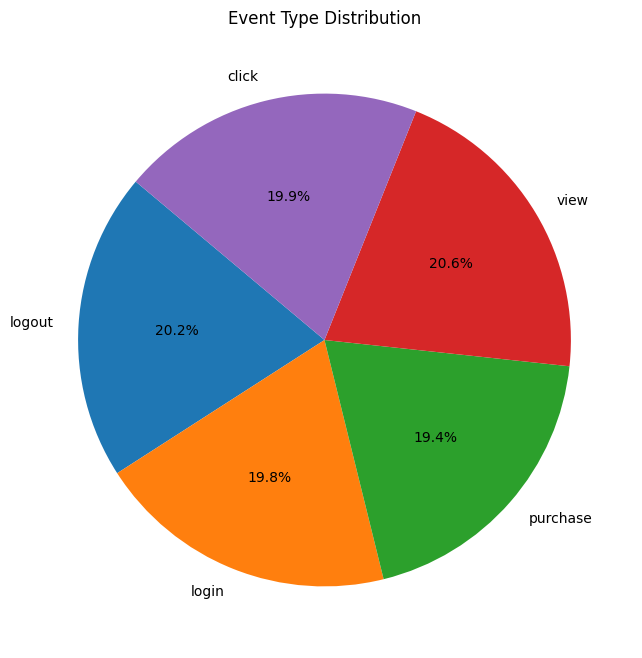

In [28]:
import matplotlib.pyplot as plt

# Data preparation: Count event types
event_type_data = spark.sql("""
    SELECT
        EventType,
        COUNT(*) AS EventCount
    FROM
        customer_interactions
    GROUP BY
        EventType
""").toPandas()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    event_type_data["EventCount"],
    labels=event_type_data["EventType"],
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Event Type Distribution")
plt.show()


In [32]:
# Data preparation: Calculate session durations
session_duration_data = spark.sql("""
    SELECT
        SessionID,
        MAX(EventTimestampUnix) - MIN(EventTimestampUnix) AS SessionDuration
    FROM
        customer_interactions_unix
    GROUP BY
        SessionID
""").toPandas()

# Plotting the box plot
fig = px.box(
    session_duration_data,
    y="SessionDuration",
    title="Session Duration Distribution",
    labels={"SessionDuration": "Session Duration (seconds)"}
)
fig.update_layout(template="plotly_white")
fig.show()


In [33]:
# Data preparation: Merge session durations with interaction counts
scatter_data = spark.sql("""
    SELECT
        ci.CustomerID,
        COUNT(ci.EventType) AS InteractionCount,
        MAX(ci.EventTimestampUnix) - MIN(ci.EventTimestampUnix) AS SessionDuration
    FROM
        customer_interactions_unix ci
    GROUP BY
        ci.CustomerID
""").toPandas()

# Plotting the scatter plot
fig = px.scatter(
    scatter_data,
    x="SessionDuration",
    y="InteractionCount",
    title="Interactions vs. Session Duration",
    labels={"SessionDuration": "Session Duration (seconds)", "InteractionCount": "Total Interactions"}
)
fig.update_layout(template="plotly_white")
fig.show()


In [34]:
# Data preparation: Aggregate events by date
events_over_time = spark.sql("""
    SELECT
        DATE(EventTimestamp) AS EventDate,
        COUNT(*) AS EventCount
    FROM
        customer_interactions
    GROUP BY
        EventDate
    ORDER BY
        EventDate
""").toPandas()

# Plotting the area chart
fig = px.area(
    events_over_time,
    x="EventDate",
    y="EventCount",
    title="Cumulative Events Over Time",
    labels={"EventDate": "Date", "EventCount": "Number of Events"}
)
fig.update_layout(template="plotly_white")
fig.show()


In [35]:
# Data preparation: Count interactions by browser and OS
bubble_data = spark.sql("""
    SELECT
        Browser,
        OS,
        COUNT(*) AS InteractionCount
    FROM
        customer_interactions
    GROUP BY
        Browser, OS
""").toPandas()

# Plotting the bubble chart
fig = px.scatter(
    bubble_data,
    x="Browser",
    y="OS",
    size="InteractionCount",
    color="InteractionCount",
    title="Bubble Chart of Interactions by Browser and OS",
    labels={"InteractionCount": "Number of Interactions"}
)
fig.update_layout(template="plotly_white")
fig.show()


In [36]:
# Stop the Spark session
spark.stop()